In [1]:
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=120)

OUTDIR = "output"
FIGDIR = "figures"
DATADIR = "data"
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(FIGDIR, exist_ok=True)
os.makedirs(DATADIR, exist_ok=True)

print("Folders:", OUTDIR, FIGDIR, DATADIR)

Folders: output figures data


In [2]:
# Stage A demo dataset (downloads automatically)
adata = sc.datasets.pbmc3k()
adata.var_names_make_unique()
adata


try downloading from url
https://falexwolf.de/data/pbmc3k_raw.h5ad
... this may take a while but only happens once


/Users/aradhana/miniforge3/envs/sc-mini/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████████████████████████████████| 5.58M/5.58M [00:01<00:00, 3.98MB/s]


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

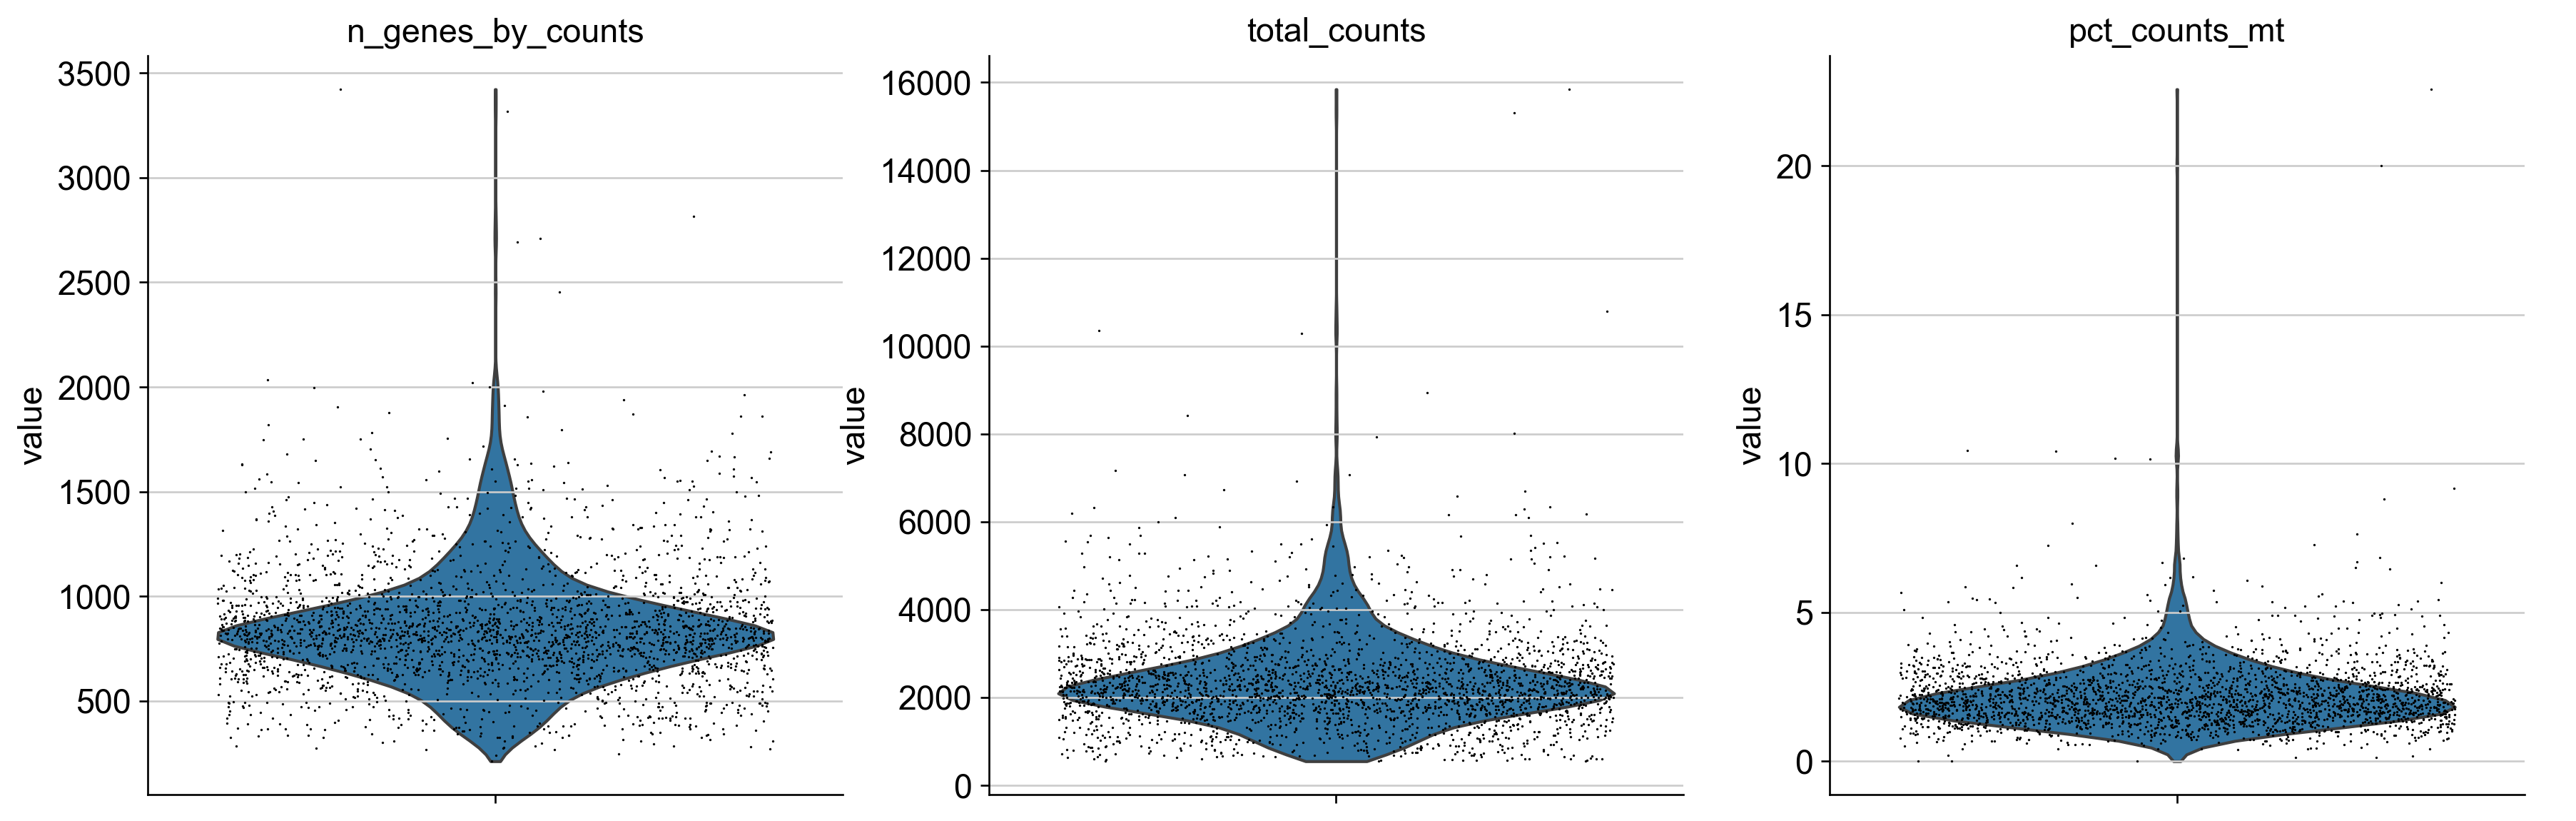

filtered out 19024 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 2698 × 13714
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [3]:
# Mark mitochondrial genes (common for human; uses gene symbols MT-*)
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

# Quick QC plots (optional)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

# Basic filters (conservative)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Remove high-mito cells (conservative threshold)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()

adata

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#Preserve full gene matrix for marker scoring later
adata.raw = adata

print("raw saved:", adata.raw is not None)

normalizing counts per cell
    finished (0:00:00)
raw saved: True


In [5]:
# Highly variable genes (subset keeps only HVGs for the graph & PCA)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

# Scale (memory-safe: doesn't densify sparse matrices)
sc.pp.scale(adata, max_value=10, zero_center=False)

# PCA + neighbors + UMAP + clustering
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)

# Leiden 
sc.tl.leiden(adata, resolution=0.6, flavor="igraph", n_iterations=2, directed=False)

adata

extracting highly variable genes
    finished (0:00:00)
... be careful when using `max_value` without `zero_center`.
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:11)
computing UMAP
    finished (0:00:07)
running Leiden clustering
    finished (0:00:00)


AnnData object with n_obs × n_vars = 2698 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

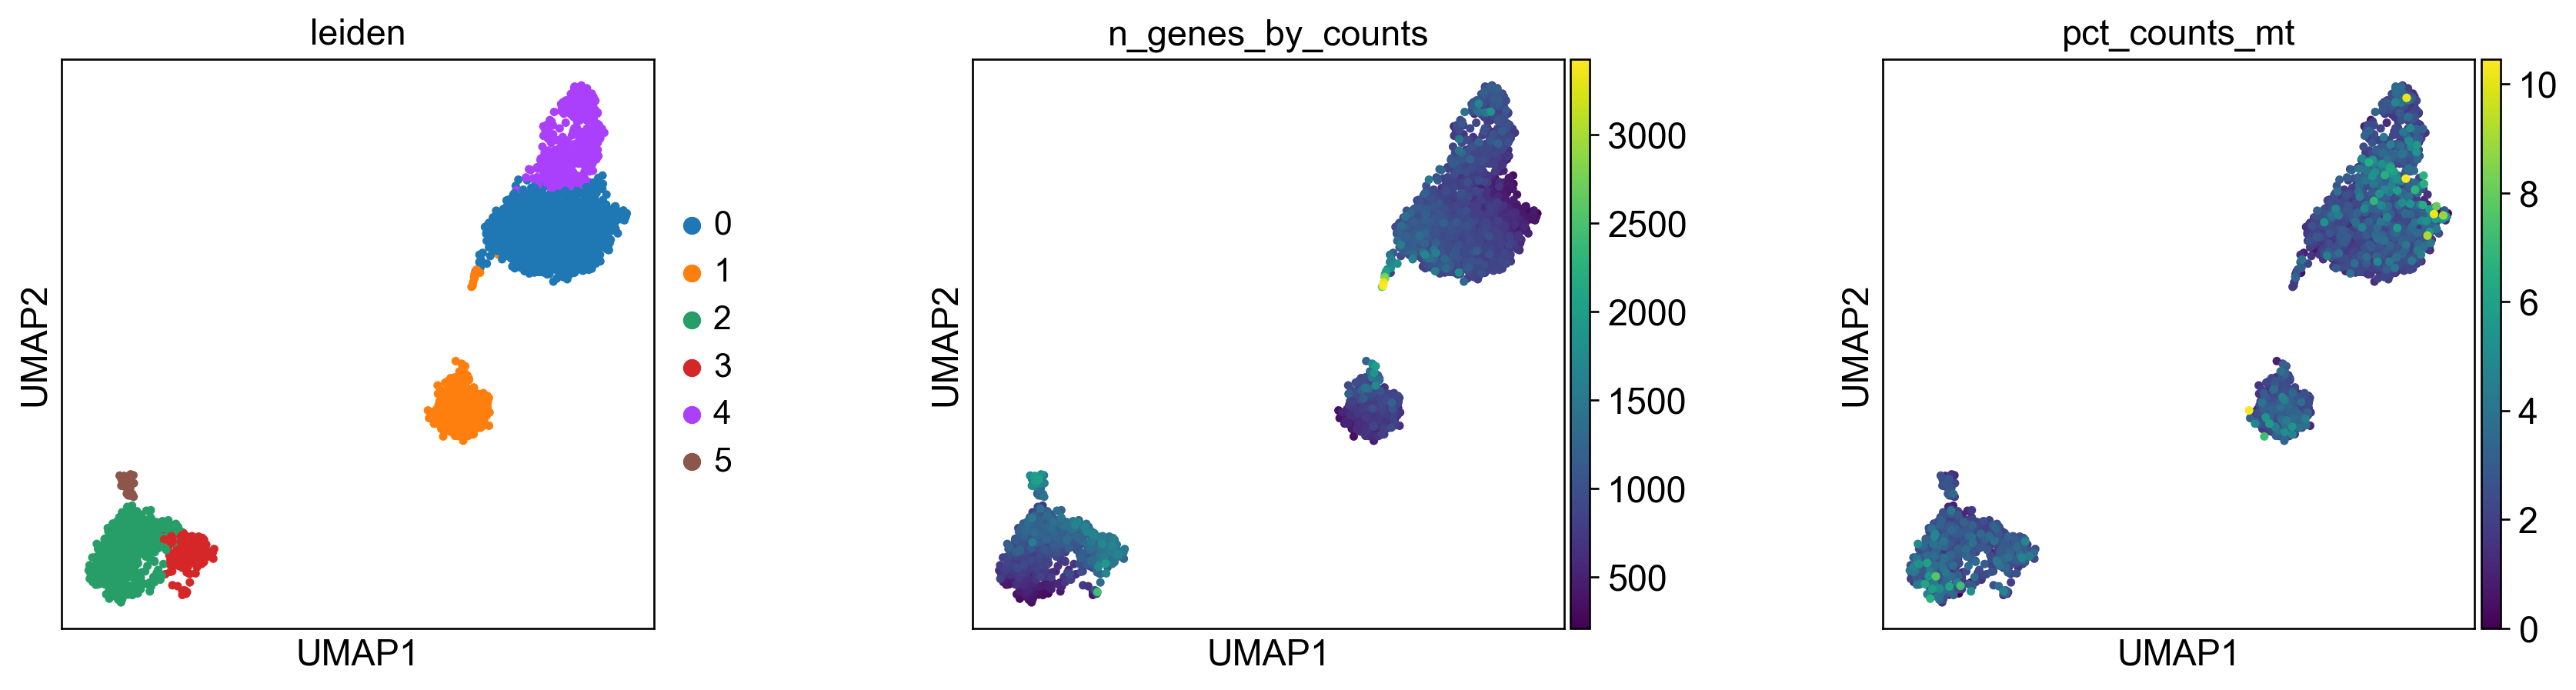

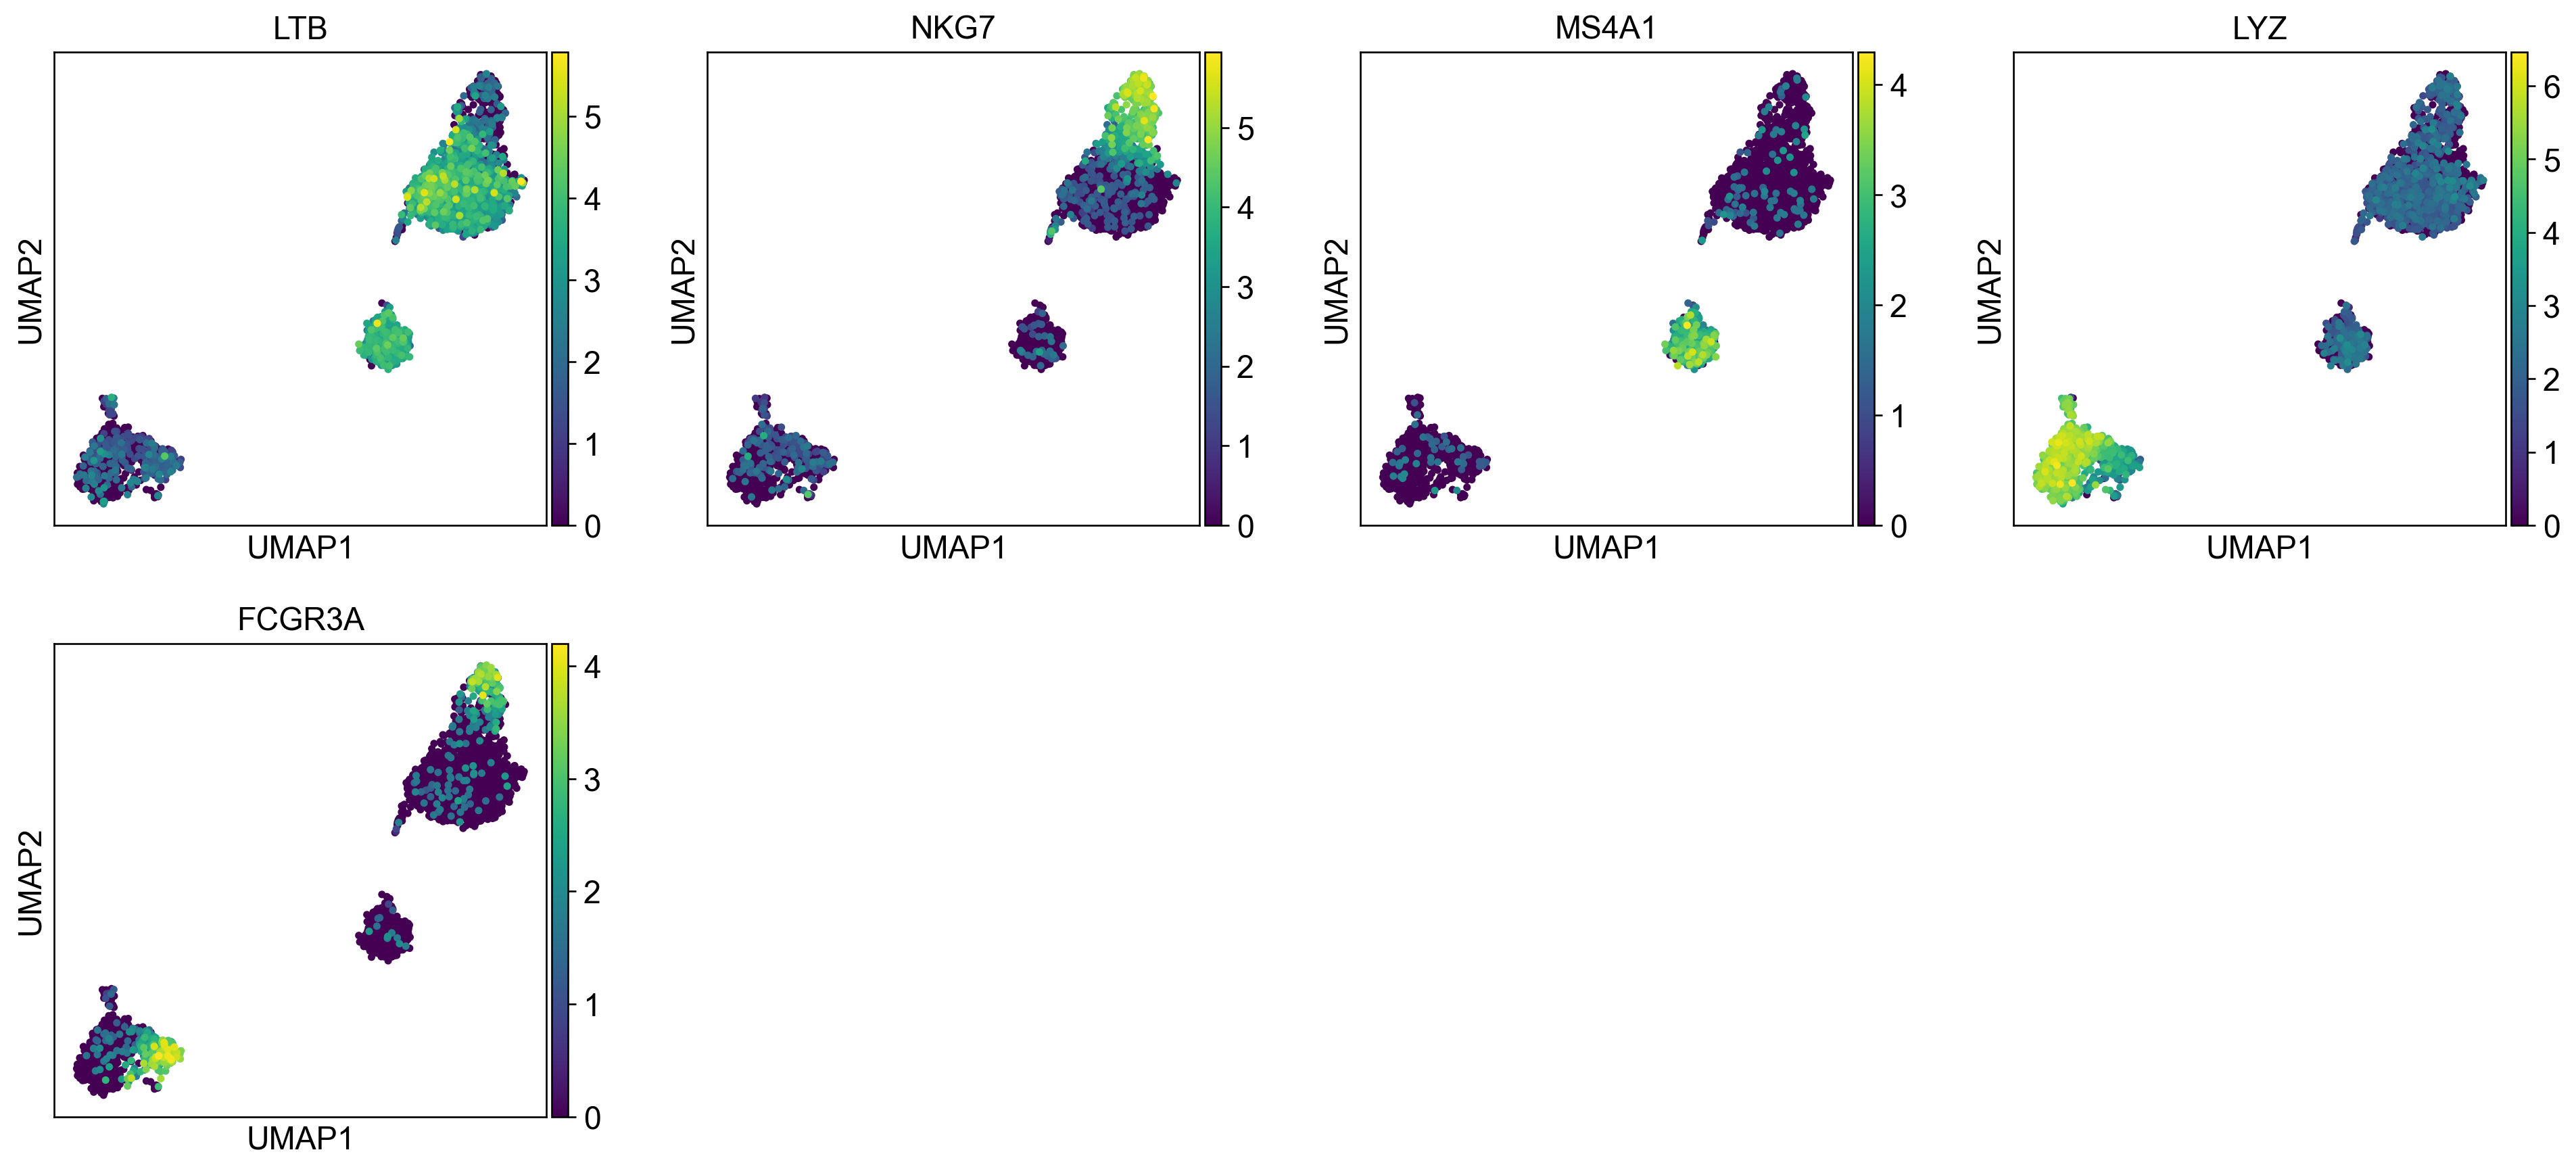

Saved: output/stageA_pbmc_processed.h5ad


In [6]:
# UMAP with clusters + QC
sc.pl.umap(adata, color=["leiden", "n_genes_by_counts", "pct_counts_mt"], wspace=0.4)

plt.savefig(os.path.join(FIGDIR, "stageA_umap_qc_clusters.png"), dpi=200, bbox_inches="tight")
plt.close()

# Marker overlays (from current HVG space; some may be missing)
markers = ["IL7R", "CCR7", "LTB", "NKG7", "MS4A1", "LYZ", "FCGR3A"]
markers_present = [g for g in markers if g in adata.var_names]

if markers_present:
    sc.pl.umap(adata, color=markers_present)
    plt.savefig(os.path.join(FIGDIR, "stageA_umap_markers.png"), dpi=200, bbox_inches="tight")
    plt.close()

# Save processed object
adata.write(os.path.join(OUTDIR, "stageA_pbmc_processed.h5ad"))
print("Saved:", os.path.join(OUTDIR, "stageA_pbmc_processed.h5ad"))

T-cell genes found: ['CD3D', 'CD3E']
CD4-ish genes found: ['IL7R', 'CCR7', 'LTB', 'MAL', 'TCF7', 'LEF1']
computing score 'tcell_score'
    finished (0:00:00)
computing score 'cd4ish_score'
    finished (0:00:00)


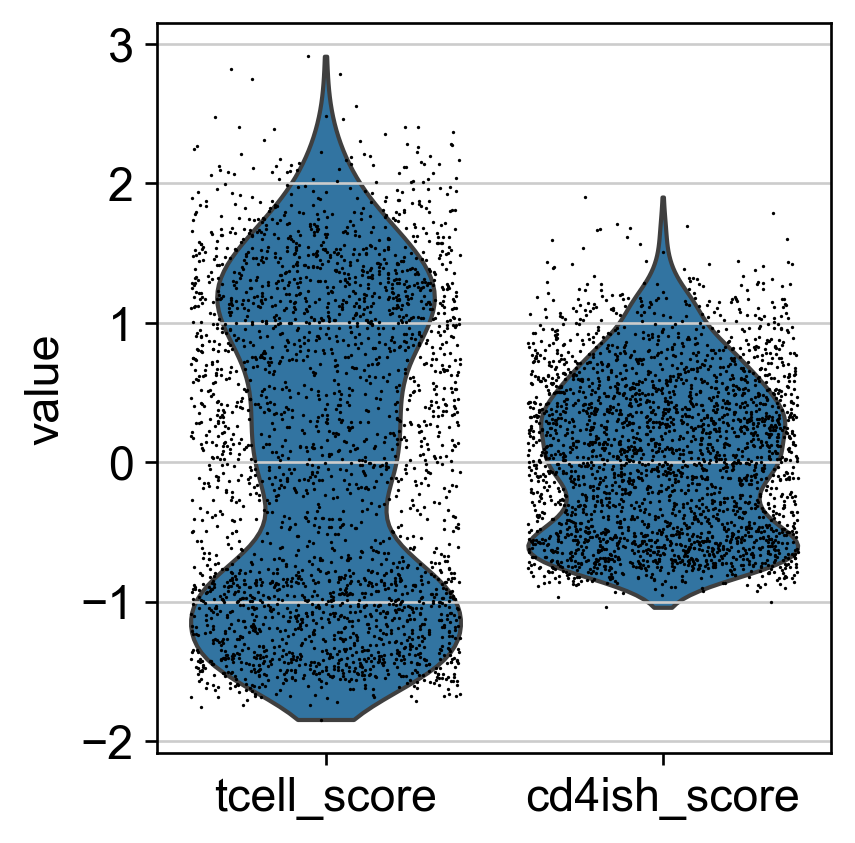

In [7]:
# used raw for marker scoring, because HVG subsetting removed many genes
if adata.raw is None:
    raise ValueError("adata.raw is missing. You must set `adata.raw = adata` right after log1p.")

raw_genes = set(adata.raw.var_names)

tcell_genes = [g for g in ["CD3D", "CD3E", "TRAC", "TRBC1", "TRBC2"] if g in raw_genes]
cd4ish_genes = [g for g in ["IL7R", "CCR7", "LTB", "MAL", "TCF7", "LEF1"] if g in raw_genes]

print("T-cell genes found:", tcell_genes)
print("CD4-ish genes found:", cd4ish_genes)

if len(tcell_genes) < 2:
    raise ValueError("T-cell markers not found in adata.raw. Dataset may use Ensembl IDs (ENSG...).")

sc.tl.score_genes(adata, gene_list=tcell_genes, score_name="tcell_score", use_raw=True)
if cd4ish_genes:
    sc.tl.score_genes(adata, gene_list=cd4ish_genes, score_name="cd4ish_score", use_raw=True)
else:
    adata.obs["cd4ish_score"] = 0.0

sc.pl.violin(adata, ["tcell_score", "cd4ish_score"], jitter=0.4)


In [8]:
t_thresh = np.quantile(adata.obs["tcell_score"], 0.75)
adata_t = adata[adata.obs["tcell_score"] > t_thresh].copy()

c_thresh = np.quantile(adata_t.obs["cd4ish_score"], 0.60)
adata_cd4 = adata_t[adata_t.obs["cd4ish_score"] > c_thresh].copy()

adata_cd4


AnnData object with n_obs × n_vars = 270 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'tcell_score', 'cd4ish_score'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [9]:
## Recompute HVGs + embedding on the subset 
sc.pp.highly_variable_genes(adata_cd4, n_top_genes=2000, subset=True)
sc.pp.scale(adata_cd4, max_value=10, zero_center=False)

sc.tl.pca(adata_cd4, svd_solver="arpack")
sc.pp.neighbors(adata_cd4, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_cd4)
sc.tl.leiden(adata_cd4, resolution=0.6, flavor="igraph", n_iterations=2, directed=False)

# Diffusion map + DPT pseudotime
sc.tl.diffmap(adata_cd4)

# Use adata_cd4.raw (same number of cells as the CD4 subset)
if adata_cd4.raw is None:
    raise ValueError("adata_cd4.raw is None. Make sure you set `adata.raw = adata` right after log1p, before HVG subsetting.")

raw_genes_cd4 = set(adata_cd4.raw.var_names)
root_markers = [g for g in ["CCR7", "IL7R", "TCF7", "LEF1"] if g in raw_genes_cd4]

root_cluster = adata_cd4.obs["leiden"].cat.categories[0]

if root_markers:
    cluster_scores = {}
    for cl in adata_cd4.obs["leiden"].cat.categories:
        idx = (adata_cd4.obs["leiden"] == cl).values  # length matches adata_cd4
        X = adata_cd4.raw[idx, root_markers].X        # used adata_cd4.raw, not adata.raw
        mean_val = float(np.asarray(X.mean()))
        cluster_scores[cl] = mean_val
    root_cluster = max(cluster_scores, key=cluster_scores.get)

root_cells = np.flatnonzero((adata_cd4.obs["leiden"] == root_cluster).values)
adata_cd4.uns["iroot"] = int(root_cells[0])

sc.tl.dpt(adata_cd4)

print("Root cluster:", root_cluster, "| root markers used:", root_markers)

extracting highly variable genes
    finished (0:00:00)
... be careful when using `max_value` without `zero_center`.
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30


/Users/aradhana/miniforge3/envs/sc-mini/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  return fn(*args_all, **kw)


    finished (0:00:00)
computing UMAP
    finished (0:00:03)
running Leiden clustering
    finished (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [ 1.          0.69578326  0.67858076  0.6574266   0.65420306  0.63737667
      0.61975527  0.6171704   0.6054297   0.593485    0.58769727 -0.58425295
     -0.6053199  -0.62615633 -0.6305871 ]
    finished (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)
Root cluster: 0 | root markers used: ['CCR7', 'IL7R', 'TCF7', 'LEF1']


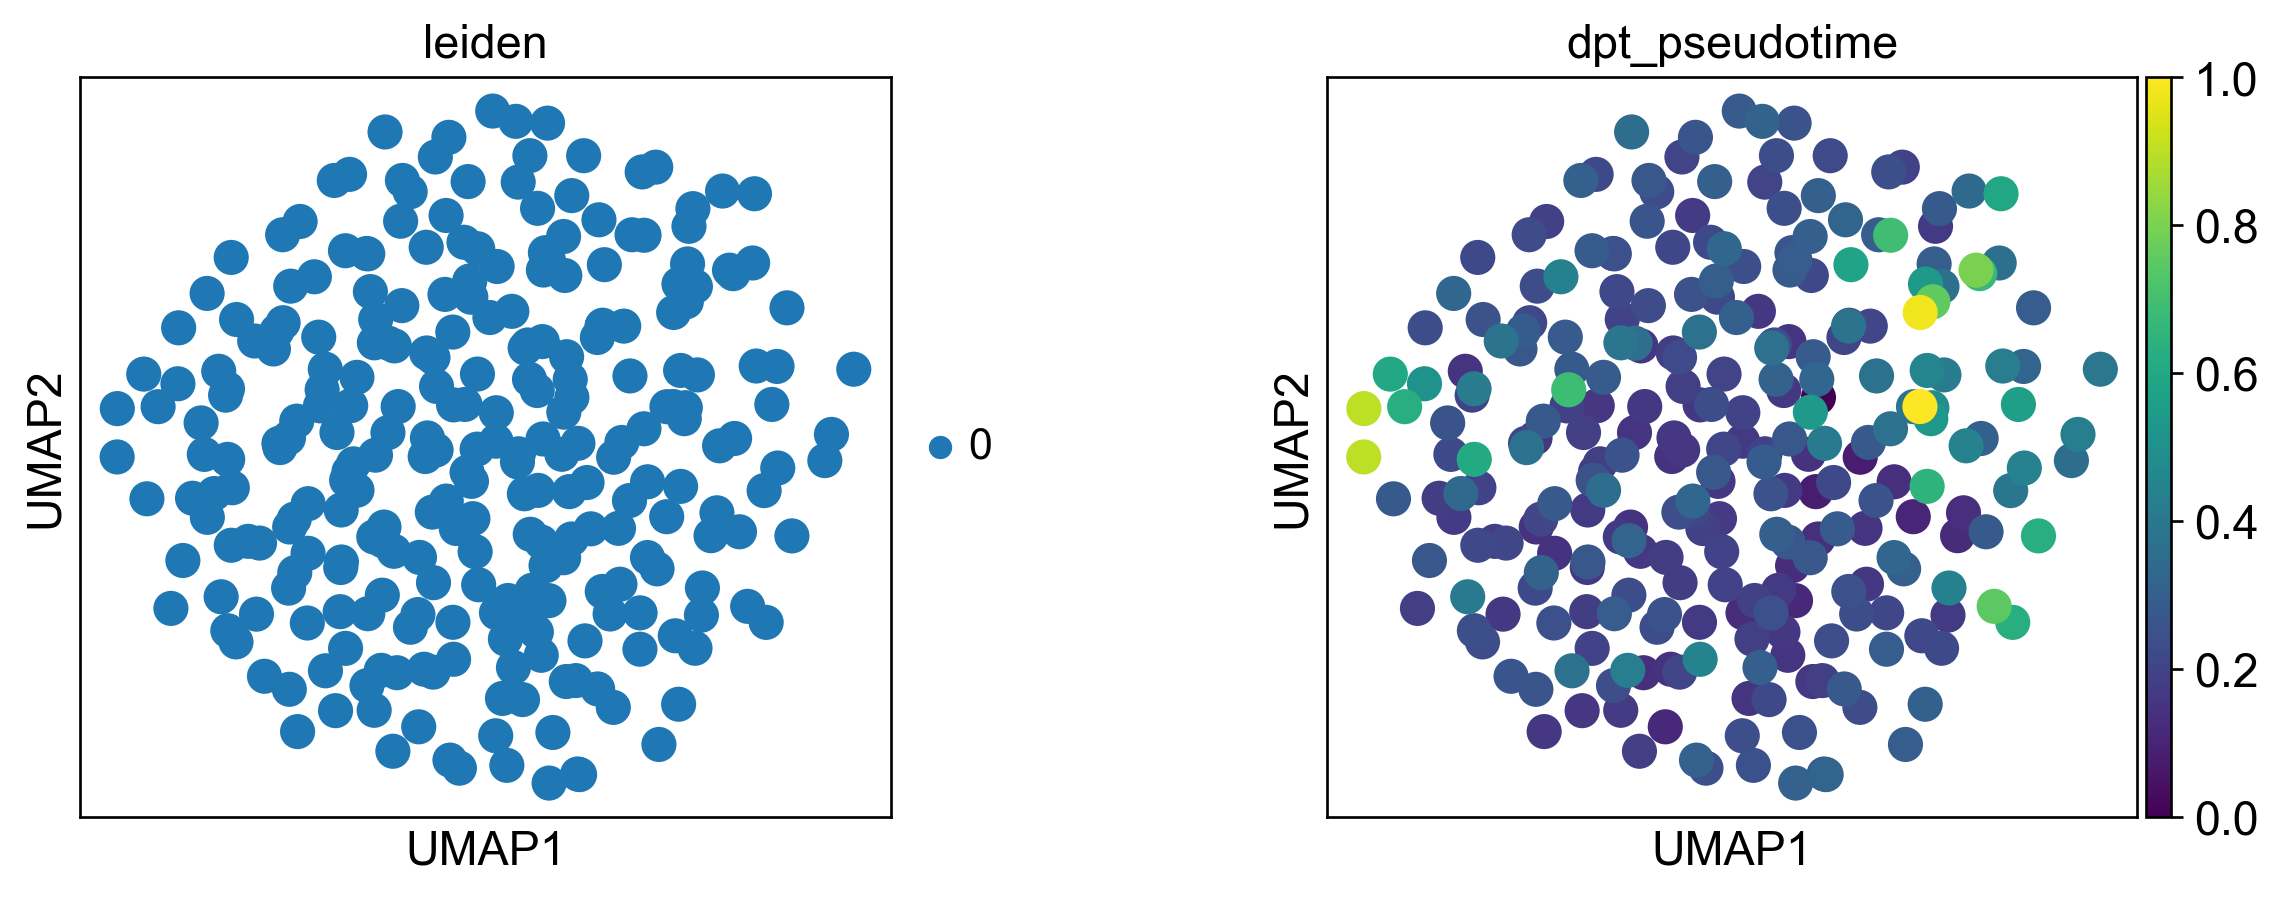

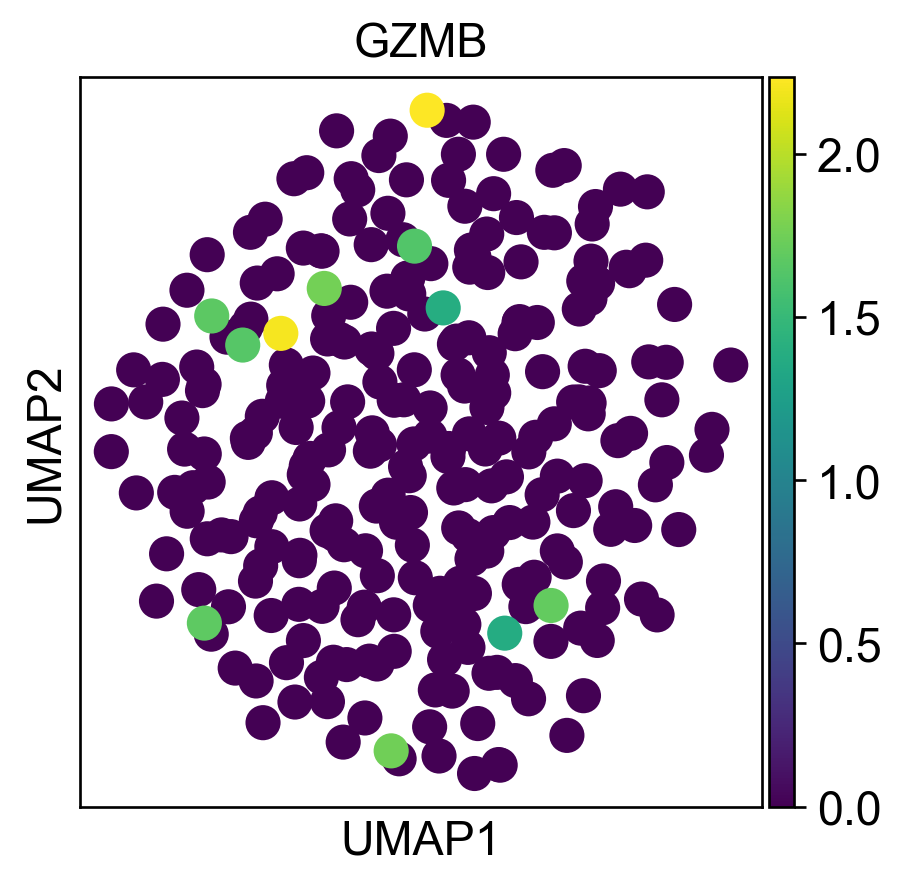

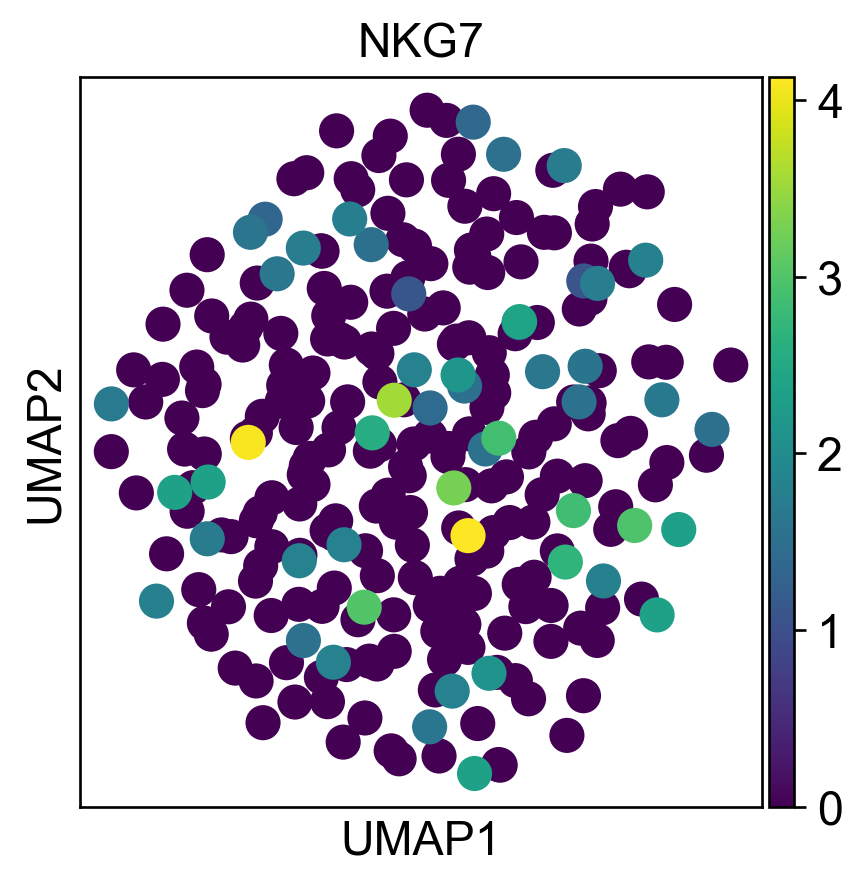

Saved: output/stageA_cd4_dpt.h5ad


In [10]:
sc.pl.umap(adata_cd4, color=["leiden", "dpt_pseudotime"], wspace=0.4)
plt.savefig(os.path.join(FIGDIR, "stageA_cd4_umap_pseudotime.png"), dpi=200, bbox_inches="tight")
plt.close()

# Marker overlays (use raw genes — but plotting in subset HVG space may miss them)
# For overlays, we can plot from raw by temporarily copying those genes in, but easiest: just plot if present here
for g in ["CCR7", "IL7R", "IFNG", "GZMB", "NKG7"]:
    if g in adata_cd4.var_names:
        sc.pl.umap(adata_cd4, color=g)
        plt.savefig(os.path.join(FIGDIR, f"stageA_cd4_umap_{g}.png"), dpi=200, bbox_inches="tight")
        plt.close()

adata_cd4.write(os.path.join(OUTDIR, "stageA_cd4_dpt.h5ad"))
print("Saved:", os.path.join(OUTDIR, "stageA_cd4_dpt.h5ad"))